# Getting Price Data

## Bitquery Historical OHLCV

In [1]:
import requests
import json
import logging
import os
from datetime import date
from dateutil.relativedelta import relativedelta
from typing import Dict, List
from time import sleep
from pathlib import Path

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.FileHandler('ohlcv_fetch.log'),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def get_solana_dex_trade_data(
    access_token: str,
    token_address: str,
    quote_currency_address: str = "So11111111111111111111111111111111111111112",
    price_asymmetry_lt: float = 0.1,
    limit_count: int = 2000,
    interval_days: int = 1,
    order_by_field: str = "Block_Timefield",
    descending: bool = True,
    dataset: str = "archive",
    retries: int = 3,
    backoff_factor: float = 2.0
) -> Dict:
    """
    Fetch historical OHLCV for a Solana token pair (Bitquery V2) with retry logic.
    
    Args:
        access_token: Bitquery API key.
        token_address: Token mint address.
        retries: Number of retry attempts for failed requests.
        backoff_factor: Multiplier for exponential backoff.
        ... (other args same as original)
    
    Returns:
        Dict: Raw API response with OHLCV data.
    
    Raises:
        RuntimeError: If all retries fail or GraphQL errors occur.
    """
    url = "https://streaming.bitquery.io/eap"
    order_direction = "descendingByField" if descending else "ascendingByField"

    query = f"""
        {{
            Solana(dataset: {dataset}) {{
                DEXTradeByTokens(
                orderBy: {{ {order_direction}: "{order_by_field}" }}
                where: {{
                    Trade: {{
                    Currency: {{ MintAddress: {{ is: "{token_address}" }} }}
                    Side:     {{ Currency: {{ MintAddress: {{ is: "{quote_currency_address}" }} }} }}
                    PriceAsymmetry: {{ lt: {price_asymmetry_lt} }}
                    }}
                }}
                limit: {{ count: {limit_count} }}
                ) {{
                Block {{
                    Timefield: Time(interval: {{ in: days, count: {interval_days} }})
                }}
                volume: sum(of: Trade_Amount)
                Trade {{
                    high:  Price(maximum: Trade_Price)
                    low:   Price(minimum: Trade_Price)
                    open:  Price(minimum: Block_Slot)
                    close: Price(maximum: Block_Slot)
                }}
                count
                }}
            }}
        }}
    """
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {access_token}",
    }

    for attempt in range(retries):
        try:
            resp = requests.post(url, json={"query": query}, headers=headers)
            resp.raise_for_status()
            data = resp.json()
            if "errors" in data:
                raise RuntimeError(f"GraphQL errors: {data['errors']}")
            logger.info(f"Successfully fetched data for {token_address}")
            return data
        except (requests.RequestException, RuntimeError) as e:
            if attempt < retries - 1:
                sleep_time = backoff_factor ** attempt
                logger.warning(f"Attempt {attempt + 1} failed for {token_address}: {e}. Retrying in {sleep_time}s...")
                sleep(sleep_time)
            else:
                logger.error(f"All {retries} attempts failed for {token_address}: {e}")
                raise RuntimeError(f"Failed to fetch data for {token_address}: {e}")

def creation_date_processing(age_str: str) -> str:
    """
    Convert age string to creation date string (YYYY-MM-DD).
    """
    num, unit, _ = age_str.split(' ')
    age = int(num)
    today = date.today()
    if unit in ('years', 'year'):
        return (today - relativedelta(years=age)).strftime('%Y-%m-%d')
    elif unit == 'months':
        return (today - relativedelta(months=age)).strftime('%Y-%m-%d')
    raise ValueError(f"Unsupported unit: {unit}")

def save_ohlcv_data(data: List[Dict], output_file: str = "ohlcv_data.json"):
    """
    Append OHLCV data to JSON file.
    """
    output_path = Path(output_file)
    if output_path.exists():
        with open(output_path, 'r', encoding='utf-8') as f:
            existing_data = json.load(f)
    else:
        existing_data = []
    
    existing_data.extend(data)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(existing_data, f, indent=2)
    logger.info(f"Saved {len(data)} records to {output_file}")

def mark_mint_processed(mint_address: str, processed_file: str = "processed_mints.txt"):
    """
    Record a mint address as processed.
    """
    with open(processed_file, 'a', encoding='utf-8') as f:
        f.write(f"{mint_address}\n")
    logger.info(f"Marked {mint_address} as processed")

def get_processed_mints(processed_file: str = "processed_mints.txt") -> set:
    """
    Load set of processed mint addresses.
    """
    if not Path(processed_file).exists():
        return set()
    with open(processed_file, 'r', encoding='utf-8') as f:
        return set(line.strip() for line in f if line.strip())

def process_pumpfun_tokens(
    csv_file: str,
    access_token: str,
    output_file: str = "ohlcv_data.json",
    processed_file: str = "processed_mints.txt"
):
    """
    Process pump.fun tokens from CSV, fetch OHLCV, save progress, and resume on restart.
    
    Args:
        csv_file: Path to pumpfundataset.csv.
        access_token: Bitquery API key.
        output_file: JSON file to store OHLCV data.
        processed_file: File to track processed mints.
    """
    processed_mints = get_processed_mints(processed_file)
    logger.info(f"Loaded {len(processed_mints)} previously processed mints")

    with open(csv_file, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            mint_address, age = [elem.strip() for elem in line.split(',')]
            
            if mint_address in processed_mints:
                logger.info(f"Skipping already processed mint: {mint_address}")
                continue

            logger.info(f"Processing mint_address {mint_address}, age: {age}")
            try:
                created_at = creation_date_processing(age)
                logger.info(f"Calculated creation date for {mint_address}: {created_at}")
                
                result = get_solana_dex_trade_data(
                    access_token=access_token,
                    token_address=mint_address,
                    limit_count=2000,
                    interval_days=1,
                )
                
                new_data = []
                for day in result["data"]["Solana"]["DEXTradeByTokens"]:
                    new_data.append({
                        "mint_address": mint_address,
                        "created_at": created_at,
                        "date": day["Block"]["Timefield"],
                        "open": day["Trade"]["open"],
                        "high": day["Trade"]["high"],
                        "low": day["Trade"]["low"],
                        "close": day["Trade"]["close"],
                        "volume": day["volume"]
                    })
                
                if new_data:
                    save_ohlcv_data(new_data, output_file)
                    logger.info(f"Fetched and saved {len(new_data)} OHLCV records for {mint_address}")
                else:
                    logger.warning(f"No OHLCV data found for {mint_address}")
                
                mark_mint_processed(mint_address, processed_file)
                
            except Exception as e:
                logger.error(f"Failed to process {mint_address}: {e}")
                continue  # Continue to next mint on failure

# Replace with your Bitquery API key or load from environment
BITQUERY_ACCESS_TOKEN = os.getenv("BITQUERY_ACCESS_TOKEN", "YOUR_API_KEY_HERE")
CSV_FILE = "pumpfundataset.csv"

if BITQUERY_ACCESS_TOKEN == "YOUR_API_KEY_HERE":
    logger.error("Please set a valid Bitquery API key")
    exit(1)

process_pumpfun_tokens(
    csv_file=CSV_FILE,
    access_token=BITQUERY_ACCESS_TOKEN,
    output_file="ohlcv_data.json",
    processed_file="processed_mints.txt"
)

2025-05-06 14:05:39,799 [INFO] Loaded 0 previously processed mints
2025-05-06 14:05:39,801 [INFO] Processing mint_address HhVM9vHUxbAiRZ9chEecxhF6UdkzveaCG1NC1C3spump, age: 3 months ago
2025-05-06 14:05:39,801 [INFO] Calculated creation date for HhVM9vHUxbAiRZ9chEecxhF6UdkzveaCG1NC1C3spump: 2025-02-06
2025-05-06 14:05:42,618 [INFO] Successfully fetched data for HhVM9vHUxbAiRZ9chEecxhF6UdkzveaCG1NC1C3spump
2025-05-06 14:05:42,623 [INFO] Saved 93 records to ohlcv_data.json
2025-05-06 14:05:42,624 [INFO] Fetched and saved 93 OHLCV records for HhVM9vHUxbAiRZ9chEecxhF6UdkzveaCG1NC1C3spump
2025-05-06 14:05:42,625 [INFO] Marked HhVM9vHUxbAiRZ9chEecxhF6UdkzveaCG1NC1C3spump as processed
2025-05-06 14:05:42,626 [INFO] Processing mint_address J1Wpmugrooj1yMyQKrdZ2vwRXG5rhfx3vTnYE39gpump, age: 9 months ago
2025-05-06 14:05:42,627 [INFO] Calculated creation date for J1Wpmugrooj1yMyQKrdZ2vwRXG5rhfx3vTnYE39gpump: 2024-08-06
2025-05-06 14:05:47,698 [INFO] Successfully fetched data for J1Wpmugrooj1yMyQ

In [ ]:
import numpy as np
import pandas as pd

def prepare_pumpdump_features(trades: pd.DataFrame) -> pd.DataFrame:
    df = trades.copy()
    # 1) normalize index
    df['t'] = pd.to_datetime(df['date'])
    df = df.sort_values('t').set_index('t')

    return df

def label_peak_phases_simple(df: pd.DataFrame) -> pd.DataFrame:
    """
    Labels the phases of a coin's price history as 'pre_peak' or 'post_peak' based on the all-time high (ATH).
    
    Args:
        df: DataFrame with 'date', 'close', and 'mint_address' columns.
        pct_within_peak: Percentage threshold around ATH to define the peak window (default 5%).
    
    Returns:
        DataFrame with a new 'phase' column.
    """
    def label_group(group):
        # Sort by date to ensure chronological order
        group = group.sort_values('date')
        
        # Find the all-time high (ATH) and its date
        ath_price = group['close'].max()
        ath_date = group.loc[group['close'].idxmax(), 'date']
        
        # Label phases based on the ATH date
        group['phase'] = group['date'].apply(
            lambda ts: 'pre_peak' if ts <= ath_date else 'post_peak'
        )
        return group
    
    # Apply the labeling function to each mint_address group
    df = df.groupby('mint_address').apply(label_group).reset_index(drop=True)
    return df

# ——— usage ———
def process_all_mints(trades: pd.DataFrame) -> pd.DataFrame:
    # ensure correct dtypes
    trades = trades.copy()
    trades['date']   = pd.to_datetime(trades['date'])
    trades['volume'] = trades['volume'].astype(float)

    # apply per‐mint workflow
    result = (
        trades
        .groupby('mint_address', group_keys=False)
        .apply(lambda grp: label_peak_phases_simple(grp))
        .reset_index()  # brings the timestamp index back into a column
    )

    return result

# usage
all_labeled = label_peak_phases_simple(pd.read_json("ohlcv_data.json"))
all_labeled = all_labeled.sort_values(['mint_address','date'])
all_labeled['days_since_launch'] = all_labeled.groupby('mint_address').cumcount() + 1
all_labeled = all_labeled.reset_index(drop=True)
all_labeled.to_csv('test.csv')

/var/folders/x_/85jw7_x578s8lj5dmcfd93fh0000gn/T/ipykernel_40321/1591537982.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('mint_address').apply(label_group).reset_index(drop=True)


In [ ]:
all_labeled.head()

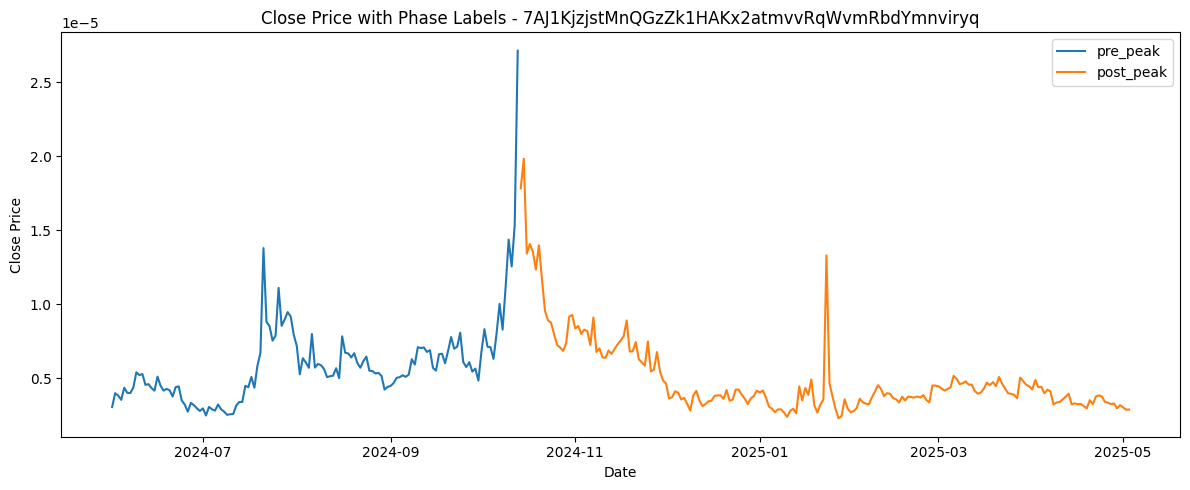

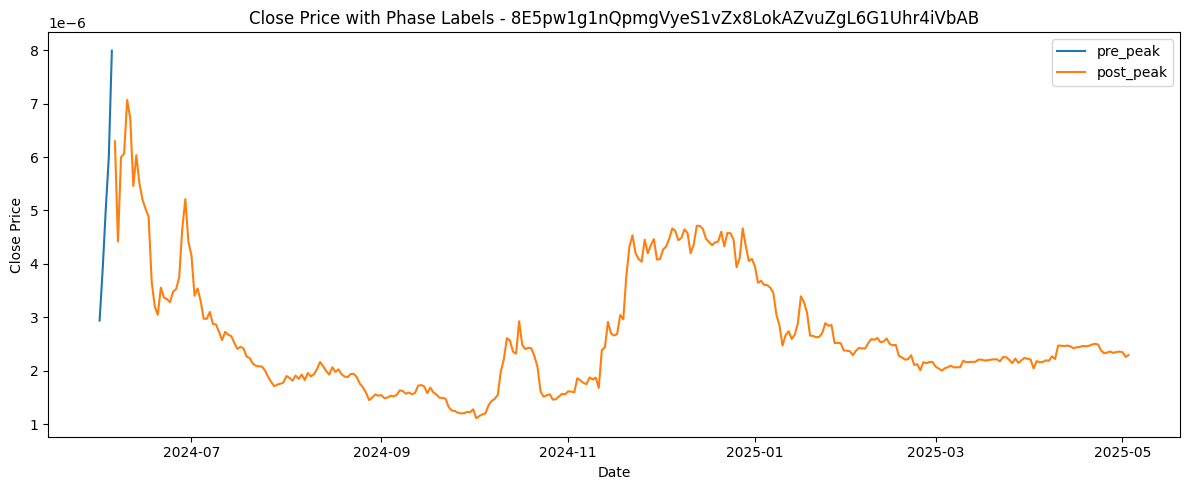

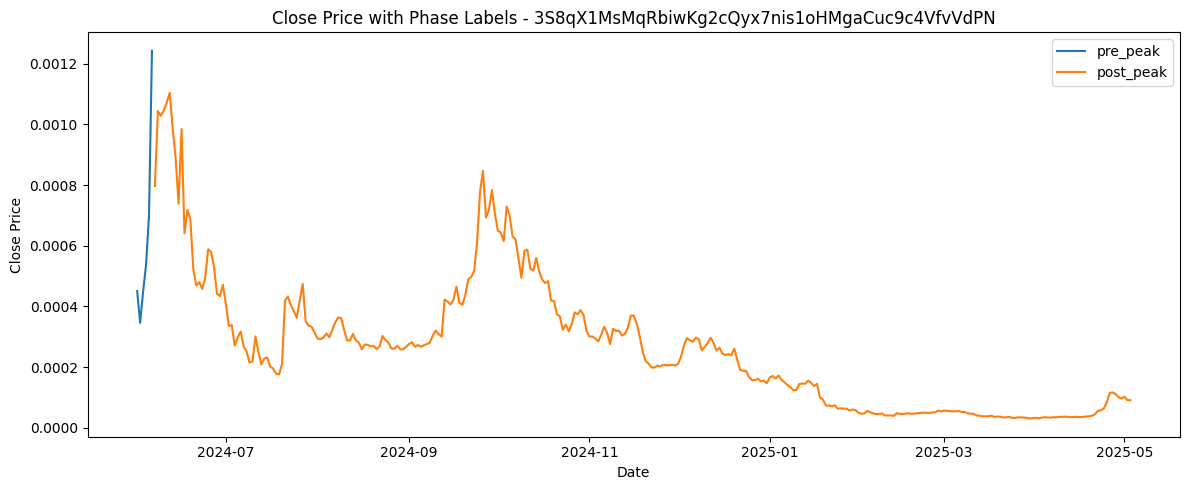

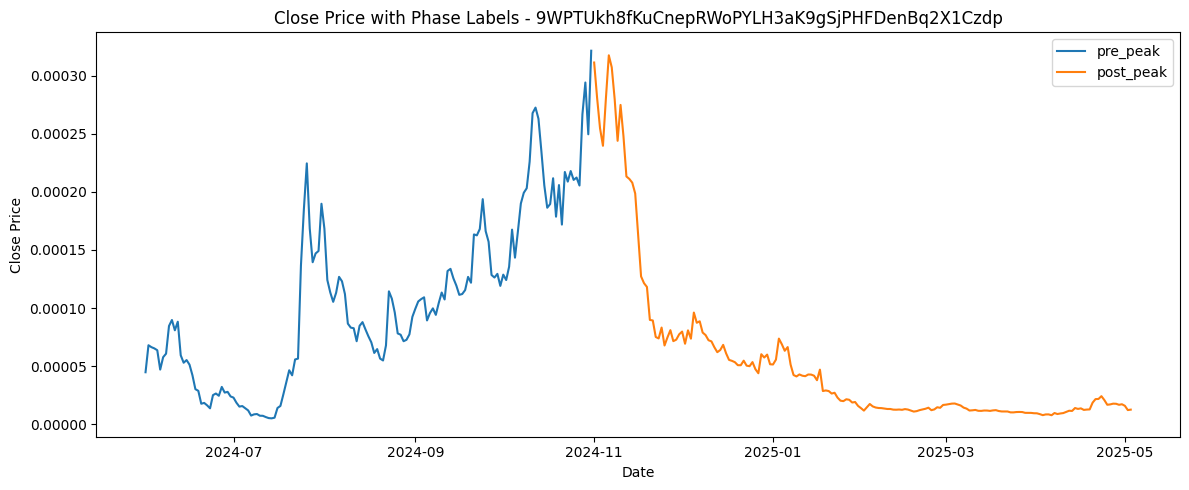

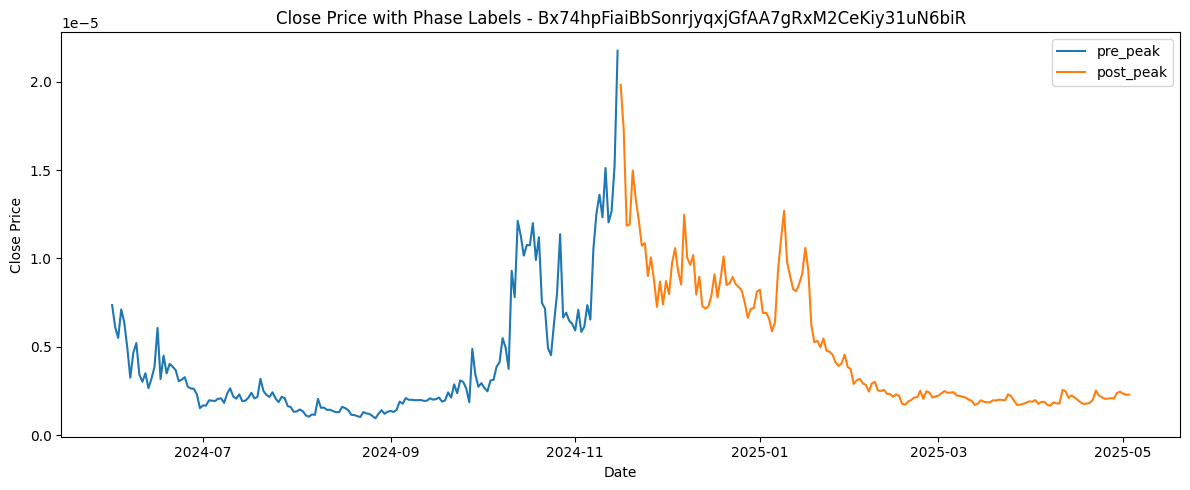

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (adjust path if needed)
df = pd.read_csv("test.csv", parse_dates=["date"])

# Select a few example tokens with enough data points
sample_mints = df['mint_address'].value_counts().head(5).index.tolist()
sample_data = df[df['mint_address'].isin(sample_mints)]

# Plot for each selected token
for mint in sample_mints:
    token_df = sample_data[sample_data['mint_address'] == mint]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    for phase in ['pre_peak', 'post_peak']:
        phase_df = token_df[token_df['phase'] == phase]
        ax.plot(phase_df['date'], phase_df['close'], label=phase)
    
    ax.set_title(f"Close Price with Phase Labels - {mint}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Close Price")
    ax.legend()
    plt.tight_layout()
    plt.show()


## load and label 

In [4]:

def load_and_label_data(file_path: str) -> pd.DataFrame:
    """
    Load the dataset and apply phase labeling based on the all-time high per coin.
    
    Args:
        file_path: Path to the CSV file containing OHLCV data.
    
    Returns:
        DataFrame with 'phase' column added.
    """
    df = pd.read_csv(file_path, parse_dates=["date"])
    df = label_peak_phases_simple(df)
    return df

## Imbalance statistics

In [5]:
import pandas as pd

def summarize_phase_imbalance(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate summary statistics for phase imbalance per coin.
    
    Args:
        df: DataFrame with 'mint_address' and 'phase' columns.
    
    Returns:
        DataFrame with counts and percentages of pre_peak and post_peak phases.
    """
    # Group by mint_address and phase, then count occurrences
    phase_counts = df.groupby(['mint_address', 'phase']).size().unstack(fill_value=0)
    
    # Calculate total rows per mint_address
    phase_counts['total'] = phase_counts.sum(axis=1)
    
    # Calculate percentages
    phase_counts['pre_peak_pct'] = (phase_counts['pre_peak'] / phase_counts['total']) * 100
    phase_counts['post_peak_pct'] = (phase_counts['post_peak'] / phase_counts['total']) * 100
    
    return phase_counts[['pre_peak', 'post_peak', 'total', 'pre_peak_pct', 'post_peak_pct']]
summarize_phase_imbalance(all_labeled).describe()

phase,pre_peak,post_peak,total,pre_peak_pct,post_peak_pct
count,612.000000,612.000000,612.000000,612.000000,612.000000
mean,44.846405,109.736928,154.583333,29.947000,70.053000
std,52.169050,71.320404,81.383664,28.040705,28.040705
min,1.000000,0.000000,5.000000,0.298507,0.000000
25%,7.000000,64.500000,97.000000,6.288920,54.233111
50%,25.500000,105.000000,143.000000,21.377793,78.622207
75%,63.000000,147.250000,190.000000,45.766889,93.711080
max,325.000000,334.000000,335.000000,100.000000,99.701493


## Modelling 

/var/folders/x_/85jw7_x578s8lj5dmcfd93fh0000gn/T/ipykernel_40321/1591537982.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('mint_address').apply(label_group).reset_index(drop=True)


Classification Report:
              precision    recall  f1-score   support

    pre_peak       0.62      0.39      0.48      5489
   post_peak       0.78      0.90      0.84     13432

    accuracy                           0.75     18921
   macro avg       0.70      0.64      0.66     18921
weighted avg       0.74      0.75      0.73     18921

ROC-AUC Score: 0.7712


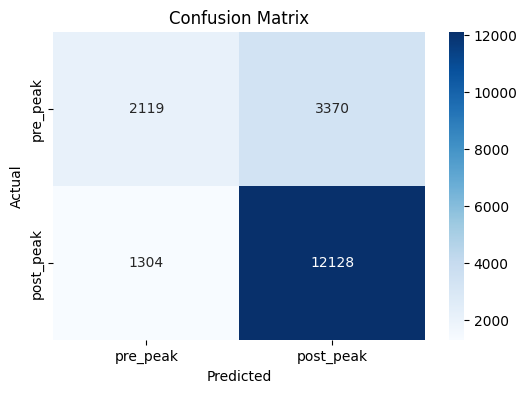

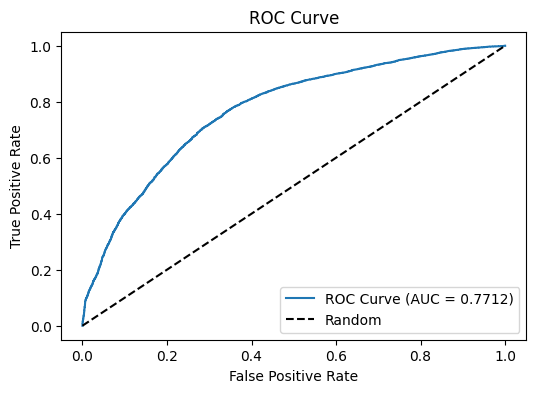

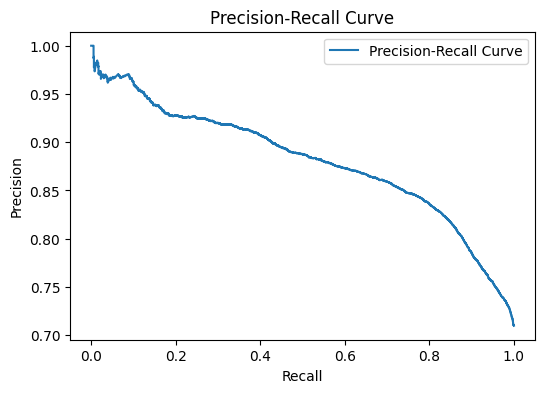

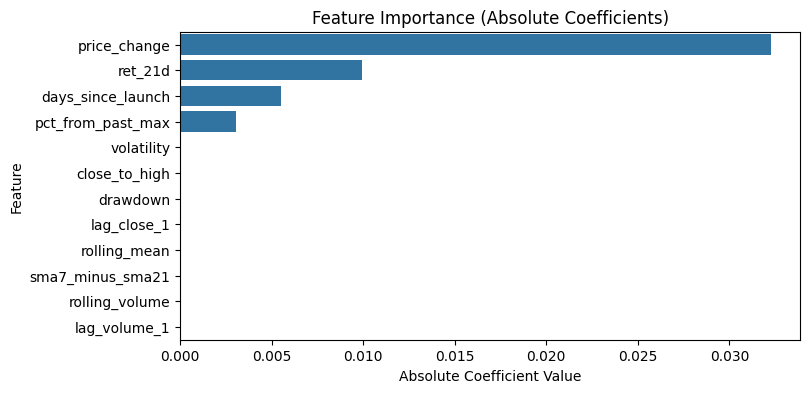

Model training complete. Check diagnostic plots: confusion_matrix.png, roc_curve.png, precision_recall_curve.png


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

def engineer_features(df: pd.DataFrame, window_size: int = 7) -> pd.DataFrame:
    """
    Engineer features for predicting peak phases based on OHLCV data.
    
    Args:
        df: DataFrame with 'date', 'close', 'open', 'high', 'low', 'volume', 'mint_address' columns.
        window_size: Number of days for rolling window calculations (default 7).
    
    Returns:
        DataFrame with engineered features.
    """
    # Sort and ensure chronological order
    df = df.sort_values(['mint_address', 'date'])
    
    # Rolling statistics
    df['price_change'] = df.groupby('mint_address')['close'].pct_change()
    df['volatility'] = df.groupby('mint_address')['price_change'].rolling(window=window_size, min_periods=1).std().reset_index(0, drop=True)
    df['rolling_mean'] = df.groupby('mint_address')['close'].rolling(window=window_size, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_volume'] = df.groupby('mint_address')['volume'].rolling(window=window_size, min_periods=1).mean().reset_index(0, drop=True)
    df['sma_7']  = df['close'].rolling(7).mean()
    df['sma_21'] = df['close'].rolling(21).mean()
    df['sma7_minus_sma21'] = df['sma_7'] - df['sma_21']
    df['ret_21d'] = df['close'].pct_change(21)
    
    # Relative price metrics
    df['close_to_high'] = df['close'] / df.groupby('mint_address')['high'].cummax()
    df['days_since_launch'] = df.groupby('mint_address').cumcount() + 1
    df['past_max_21d'] = df.groupby('mint_address')['close'].transform(
        lambda x: x.shift(1).rolling(21, min_periods=1).max()
    )
    df['pct_from_past_max'] = df['close'] / df['past_max_21d'] - 1


    # Lag features
    df['lag_close_1'] = df.groupby('mint_address')['close'].shift(1)
    df['lag_volume_1'] = df.groupby('mint_address')['volume'].shift(1)
    
    # drawdown vs. 1-week high
    df['max21d']   = df['close'].rolling(21, min_periods=1).max()
    df['drawdown'] = df['close'] / df['max21d'] - 1

    # Handle NaN values
    df = df.fillna(0)
    
    return df

def prepare_training_data(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    """
    Prepare features and target for modeling.
    
    Args:
        df: DataFrame with engineered features and 'phase' column.
    
    Returns:
        Tuple of (features DataFrame, target Series).
    """
    features = df[['price_change', 'volatility', 'rolling_mean', 'rolling_volume', 
                   'close_to_high', 'days_since_launch', 'lag_close_1', 'lag_volume_1', 
                   "sma7_minus_sma21", "ret_21d", "pct_from_past_max", "drawdown"]]
    target = df['phase'].map({'pre_peak': 0, 'post_peak': 1})
    return features, target



def train_and_evaluate_logistic_regression(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, random_state: int = 42):
    """
    Train a logistic regression model, evaluate performance, and generate diagnostic plots.
    
    Args:
        X: Feature DataFrame.
        y: Target Series (0 for pre_peak, 1 for post_peak).
        test_size: Proportion of data to use for testing (default 0.2).
        random_state: Seed for reproducibility (default 42).
    
    Returns:
        Trained model and performance metrics.
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Train the logistic regression model with class weighting
    model = LogisticRegression(class_weight='balanced', random_state=random_state, max_iter=1000)
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Performance Metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['pre_peak', 'post_peak']))
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Diagnostic Plots
    # 1. Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pre_peak', 'post_peak'], yticklabels=['pre_peak', 'post_peak'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('images/confusion_matrix.png')
    plt.show()
    plt.close()
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('images/roc_curve.png')
    plt.show()
    plt.close()
    
    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.savefig('images/precision_recall_curve.png')
    plt.show()
    plt.close()

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'coefficient': np.abs(model.coef_[0])  # Absolute value for importance
    }).sort_values('coefficient', ascending=False)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x='coefficient', y='feature', data=feature_importance)
    plt.title('Feature Importance (Absolute Coefficients)')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.savefig('images/feature_importance.png')
    plt.show()
    plt.close()
    
    return model, {'roc_auc': roc_auc}

# Example usage (you can run this after preparing the data with previous functions)
# Assuming data is prepared using previous functions
df = load_and_label_data("test.csv")
df = engineer_features(df)
X, y = prepare_training_data(df)
model, metrics = train_and_evaluate_logistic_regression(X, y)
print("Model training complete. Check diagnostic plots: confusion_matrix.png, roc_curve.png, precision_recall_curve.png")

## XGBoost

Loading data and preparing features with fixed methodology...


/var/folders/x_/85jw7_x578s8lj5dmcfd93fh0000gn/T/ipykernel_40321/1591537982.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('mint_address').apply(label_group).reset_index(drop=True)
/var/folders/x_/85jw7_x578s8lj5dmcfd93fh0000gn/T/ipykernel_40321/1591537982.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('mint_address').apply(label_group).reset_index(drop=True)


Training class distribution: pre_peak=16416, post_peak=39518


/Users/matthewcarter/Documents/repos/fraudbuster-rug-pull-detector/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:17:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

    pre_peak       0.64      0.73      0.68     11030
   post_peak       0.88      0.84      0.86     27641

    accuracy                           0.81     38671
   macro avg       0.76      0.78      0.77     38671
weighted avg       0.81      0.81      0.81     38671

ROC-AUC Score: 0.8600


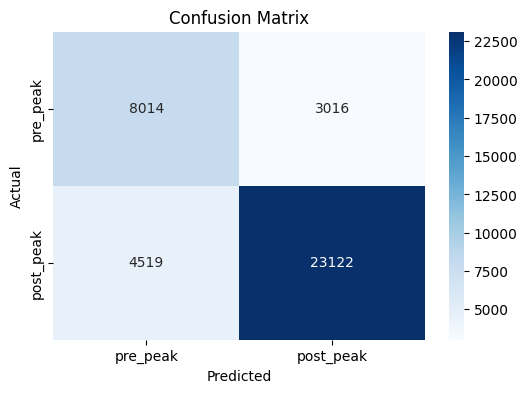

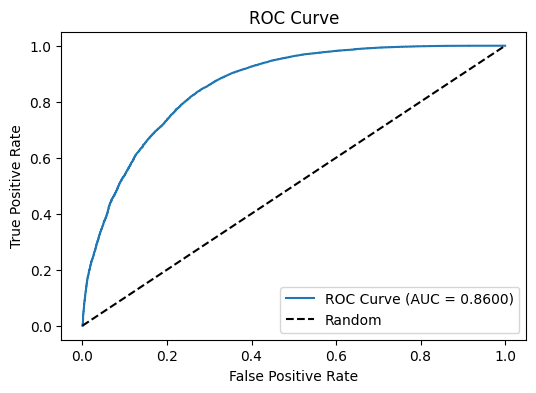

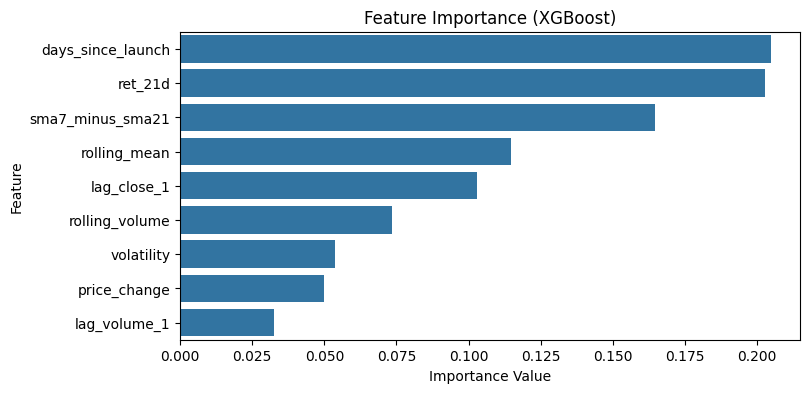


Fixed model training complete. Check diagnostic plots.


In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


def load_and_prepare_data(file_path: str) -> tuple:
    """
    Load the dataset, split into train/test sets, then engineer features separately
    to prevent leakage.
    
    Args:
        file_path: Path to the CSV file containing OHLCV data.
        split_date: Date to split train and test sets.
    
    Returns:
        Tuple of (X_train, X_test, y_train, y_test).
    """
    # Load data
    df = pd.read_csv(file_path, parse_dates=["date"])
    df = df.sort_values(['mint_address', 'date'])
    
    unique = df['mint_address'].unique()
    test_coins = np.random.choice(unique, size=int(0.4*len(unique)), replace=False)
    train_df = df[~df['mint_address'].isin(test_coins)]
    test_df  = df[ df['mint_address'].isin(test_coins)]
    
    # Now label each dataset separately
    train_df = label_peak_phases_simple(train_df)
    test_df = label_peak_phases_simple(test_df)
    
    # Engineer features separately for train and test
    train_df = engineer_features(train_df)
    test_df = engineer_features(test_df)
    
    # Define non-leaking features
    # Removed features that directly encode the target: close_to_high, pct_from_past_max, drawdown
    features = [
        'price_change', 'volatility', 'rolling_mean', 'rolling_volume',
        'days_since_launch', 'lag_close_1', 'lag_volume_1', 
        'sma7_minus_sma21', 'ret_21d'
    ]
    
    # Prepare features and target
    X_train = train_df[features].copy()
    y_train = train_df['phase'].map({'pre_peak': 0, 'post_peak': 1})
    X_test = test_df[features].copy()
    y_test = test_df['phase'].map({'pre_peak': 0, 'post_peak': 1})
    
    # Handle missing values properly
    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)
    
    return X_train, X_test, y_train, y_test

def engineer_features(df: pd.DataFrame, window_size: int = 7) -> pd.DataFrame:
    """
    Engineer time-aware features without leakage. Each calculation only uses
    data available before the current point.
    
    Args:
        df: DataFrame with OHLCV data.
        window_size: Number of days for rolling window calculations.
    
    Returns:
        DataFrame with engineered features.
    """
    df = df.copy()
    
    # Basic features that use only past data
    df['price_change'] = df.groupby('mint_address')['close'].pct_change()
    df['volatility'] = df.groupby('mint_address')['price_change'].rolling(window=window_size, min_periods=1).std().reset_index(0, drop=True)
    df['rolling_mean'] = df.groupby('mint_address')['close'].rolling(window=window_size, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_volume'] = df.groupby('mint_address')['volume'].rolling(window=window_size, min_periods=1).mean().reset_index(0, drop=True)
    
    # Technical indicators using only past data
    df['sma_7'] = df.groupby('mint_address')['close'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
    df['sma_21'] = df.groupby('mint_address')['close'].rolling(21, min_periods=1).mean().reset_index(0, drop=True)
    df['sma7_minus_sma21'] = df['sma_7'] - df['sma_21']
    df['ret_21d'] = df.groupby('mint_address')['close'].pct_change(21)
    
    # Time features
    df['days_since_launch'] = df.groupby('mint_address').cumcount() + 1
    
    # Lagged features (clearly from the past)
    df['lag_close_1'] = df.groupby('mint_address')['close'].shift(1)
    df['lag_volume_1'] = df.groupby('mint_address')['volume'].shift(1)
    
    return df

def train_and_evaluate_xgboost(X_train, X_test, y_train, y_test, random_state=42):
    """
    Train an XGBoost classifier and evaluate performance.
    
    Args:
        X_train, X_test: Feature DataFrames for training and testing.
        y_train, y_test: Target Series (0 for pre_peak, 1 for post_peak).
        random_state: Seed for reproducibility.
    
    Returns:
        Trained model and performance metrics.
    """

    X_train_res, y_train_res = X_train, y_train
    
    # Get class distribution
    class_counts = y_train_res.value_counts()
    print(f"Training class distribution: pre_peak={class_counts.get(0, 0)}, post_peak={class_counts.get(1, 0)}")
    
    # Train with appropriate weight balancing
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state,
        scale_pos_weight=len(y_train_res[y_train_res == 0]) / max(1, len(y_train_res[y_train_res == 1]))
    )
    
    model.fit(X_train_res, y_train_res)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Performance Metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['pre_peak', 'post_peak']))
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pre_peak', 'post_peak'], yticklabels=['pre_peak', 'post_peak'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('images/xgboost_confusion_matrix_fixed.png')
    plt.show()
    plt.close()
    
    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig('images/xgboost_roc_curve_fixed.png')
    plt.show()
    plt.close()
    
    # Feature Importance Plot
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance (XGBoost)')
    plt.xlabel('Importance Value')
    plt.ylabel('Feature')
    plt.savefig('images/xgboost_feature_importance_fixed.png')
    plt.show()
    plt.close()
    
    return model, {'roc_auc': roc_auc}

# Run the fixed pipeline
print("Loading data and preparing features with fixed methodology...")
X_train, X_test, y_train, y_test = load_and_prepare_data("test.csv")

model1, metrics1 = train_and_evaluate_xgboost(X_train, X_test, y_train, y_test)

print("\nFixed model training complete. Check diagnostic plots.")

In [8]:
model1.save_model('model.ubj')